<a href="https://colab.research.google.com/github/AnamarijaKozina/Duboko-ucenje-FER/blob/main/mnist_shootout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import random
import torchvision

In [3]:
class Random2DGaussian:
  """Random bivariate normal distribution sampler

  Hardwired parameters:
      d0min,d0max: horizontal range for the mean
      d1min,d1max: vertical range for the mean
      scalecov: controls the covariance range 

  Methods:
      __init__: creates a new distribution

      get_sample(n): samples n datapoints

  """

  d0min=0 
  d0max=10
  d1min=0 
  d1max=10
  scalecov=5
  
  def __init__(self):
    dw0,dw1 = self.d0max-self.d0min, self.d1max-self.d1min
    mean = (self.d0min,self.d1min)
    mean += np.random.random_sample(2)*(dw0, dw1)
    eigvals = np.random.random_sample(2)
    eigvals *= (dw0/self.scalecov, dw1/self.scalecov)
    eigvals **= 2
    theta = np.random.random_sample()*np.pi*2
    R = [[np.cos(theta), -np.sin(theta)], 
         [np.sin(theta), np.cos(theta)]]
    Sigma = np.dot(np.dot(np.transpose(R), np.diag(eigvals)), R)
    self.get_sample = lambda n: np.random.multivariate_normal(mean,Sigma,n)

  
def graph_surface(function, model, rect, offset=0.5, width=256, height=256):
  """Creates a surface plot (visualize with plt.show)

  Arguments:
    function: surface to be plotted
    rect:     function domain provided as:
              ([x_min,y_min], [x_max,y_max])
    offset:   the level plotted as a contour plot

  Returns:
    None
  """

  lsw = np.linspace(rect[0][1], rect[1][1], width) 
  lsh = np.linspace(rect[0][0], rect[1][0], height)
  xx0,xx1 = np.meshgrid(lsh, lsw)
  grid = np.stack((xx0.flatten(),xx1.flatten()), axis=1)
  

  #get the values and reshape them
  values=function(model,grid).reshape((width,height))
  
  # fix the range and offset
  delta = offset if offset else 0
  maxval=max(np.max(values)-delta, - (np.min(values)-delta))
  
  # draw the surface and the offset
  plt.pcolormesh(xx0, xx1, values, 
     vmin=delta-maxval, vmax=delta+maxval)
    
  if offset != None:
    plt.contour(xx0, xx1, values, colors='black', levels=[offset])

def graph_data(X,Y_, Y, special=[]):
  """Creates a scatter plot (visualize with plt.show)

  Arguments:
      X:       datapoints
      Y_:      groundtruth classification indices
      Y:       predicted class indices
      special: use this to emphasize some points

  Returns:
      None
  """
  # colors of the datapoint markers
  palette=([0.5,0.5,0.5], [1,1,1], [0.2,0.2,0.2])
  colors = np.tile([0.0,0.0,0.0], (Y_.shape[0],1))
  for i in range(len(palette)):
    colors[Y_==i] = palette[i]

  # sizes of the datapoint markers
  sizes = np.repeat(20, len(Y_))
  sizes[special] = 40
  
  # draw the correctly classified datapoints
  good = (Y_==Y)
  plt.scatter(X[good,0],X[good,1], c=colors[good], 
              s=sizes[good], marker='o', edgecolors='black')

  # draw the incorrectly classified datapoints
  bad = (Y_!=Y)
  plt.scatter(X[bad,0],X[bad,1], c=colors[bad], 
              s=sizes[bad], marker='s', edgecolors='black')

def class_to_onehot(Y):
  Yoh=np.zeros((len(Y),max(Y)+1))
  Yoh[range(len(Y)),Y] = 1
  return Yoh

def eval_perf_multi(Y, Y_):
  pr = []
  n = max(Y_)+1
  M = np.bincount(n * Y_ + Y, minlength=n*n).reshape(n, n)
  for i in range(n):
    tp_i = M[i,i]
    fn_i = np.sum(M[i,:]) - tp_i
    fp_i = np.sum(M[:,i]) - tp_i
    tn_i = np.sum(M) - fp_i - fn_i - tp_i
    recall_i = tp_i / (tp_i + fn_i + 1e-15)
    precision_i = tp_i / (tp_i + fp_i + 1e-15)
    pr.append( (recall_i, precision_i) )
  
  accuracy = np.trace(M)/np.sum(M)
  
  return accuracy, pr, M

def eval_AP(ranked_labels):
  """Recovers AP from ranked labels"""
  
  n = len(ranked_labels)
  pos = sum(ranked_labels)
  neg = n - pos
  
  tp = pos
  tn = 0.
  fn = 0.
  fp = neg
  
  sumprec=0
  #IPython.embed()
  for x in ranked_labels:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)    

    if x:
      sumprec += precision
      
    #print (x, tp,tn,fp,fn, precision, recall, sumprec)
    #IPython.embed()

    tp -= x
    fn += x
    fp -= not x
    tn += not x

  return sumprec/pos

def sample_gmm_2d(ncomponents, nclasses, nsamples):
  # create the distributions and groundtruth labels
  Gs=[]
  Ys=[]
  for i in range(ncomponents):
    Gs.append(Random2DGaussian())
    Ys.append(np.random.randint(nclasses))

  # sample the dataset
  X = np.vstack([G.get_sample(nsamples) for G in Gs])
  Y_= np.hstack([[Y]*nsamples for Y in Ys])
  
  return X,Y_

In [4]:
class PTDeep(nn.Module):
  def __init__(self, layer_sizes, activation = torch.relu): 
    super().__init__()

    self.layers = len(layer_sizes)-1

    self.weights = nn.ParameterList([nn.Parameter(torch.randn(layer_sizes[i], layer_sizes[i+1]), requires_grad=True) for i in range(self.layers)]).cuda()
    self.biases = nn.ParameterList([nn.Parameter(torch.randn(layer_sizes[i+1]), requires_grad=True) for i in range(self.layers)]).cuda()

    self.activation = activation

  def forward(self, X): # X: N x dim
    for i in range(self.layers-1):
      X = torch.mm(X, self.weights[i]) + self.biases[i]
      X = self.activation(X)
    X = torch.mm(X, self.weights[self.layers-1]) + self.biases[self.layers-1]
    return torch.softmax(X, axis=1)

  def get_loss(self, X, Yoh_, param_lambda=0.0): 
 
    Y_pred = self.forward(X).cuda()
    reg = 0
    if param_lambda>0:
      reg = sum([torch.norm(w) for w in self.weights])/X.shape[0]
    r1 = torch.log(Y_pred+1e-15)*Yoh_
    r2 = torch.sum(r1, axis=1)
    loss = - torch.mean(r2) + (reg * param_lambda)
    
    return loss

  def count_params(self):
    for name, p in self.named_parameters():
      print(f'Parametar {name} ima oblik {p.shape}')


def train(model, X, Yoh_, param_niter, param_delta, param_lambda=0.0):

  optimizer = torch.optim.SGD(model.parameters(), lr = param_delta)
  losses = []
  for iter in range(param_niter):
    optimizer.zero_grad()
    loss = model.get_loss(X, Yoh_, param_lambda)
    losses.append(loss)
    if (iter+1)%500==0:
      print(f"Korak {iter+1}, gubitak = {loss}")
    loss.backward()
    optimizer.step()
  
  print("Gubitak tijekom epoha:")
  losses = torch.tensor(losses).cpu()
  plt.plot(losses)
  plt.show()
  
def train_with_batches_and_evaluate(model, X, Yoh, x_val, y_val, param_niter, param_delta, batch_size=64, param_lambda=0.0, variable_learning_rate=False):
  optimizer = torch.optim.Adam(model.parameters(), lr = param_delta)
  scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=1-param_delta)
  total_losses= []
  best_acc = 0.0
  best_model = None
  best_iter = None
  
  for iter in range(param_niter):
    perm = torch.randperm(X.shape[0])
    x_batches = [x.cuda() for x in torch.split(X[perm], batch_size)]
    y_batches = [x.cuda() for x in torch.split(Yoh[perm], batch_size)]
    losses=[]
    for i, (features, target) in enumerate(zip(x_batches, y_batches)):
      optimizer.zero_grad()
      loss = model.get_loss(features, target, param_lambda)
      loss.backward()
      optimizer.step()
      losses.append(loss)
    total_loss = sum(losses)/len(losses)
    total_losses.append(total_loss)
    if variable_learning_rate:
      scheduler.step()
    if (iter+1)%10==0:
      print(f"Korak {iter+1}, gubitak = {total_loss}")
    acc = performance(model, x_val, y_val, printing=False)
    if acc>best_acc:
      best_model=model
      best_iter = iter
      best_acc=acc

  print("Gubitak tijekom epoha:")
  total_losses = torch.tensor(total_losses).cpu()
  plt.plot(total_losses)
  plt.show()
  print(f"Najbolji performans model ima nakon {best_iter}. epohe, kada je tocnost na validacijskom skupu {best_acc}.")
  return best_model

def eval(model, X):
  outputs = model.forward(X).cpu().detach().numpy() # N x C
  return outputs

In [5]:
from matplotlib.rcsetup import validate_color
dataset_root = ''  # change this to your preference
mnist_train = torchvision.datasets.MNIST(dataset_root, train=True, download=True)
mnist_test = torchvision.datasets.MNIST(dataset_root, train=False, download=True)


x_train, y_train = mnist_train.data, mnist_train.targets
x_test, y_test = mnist_test.data, mnist_test.targets
x_train, x_test = x_train.float().div_(255.0), x_test.float().div_(255.0)
x_train_v = x_train[:48000]
y_train_v = y_train[:48000]
x_val = x_train[48000:]
y_val = y_train[48000:]

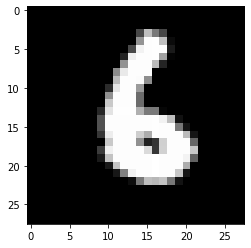

In [6]:

plt.imshow(x_train[36], cmap = plt.get_cmap('gray'))

In [7]:
def performance(model, x, y, printing = True): #x and y must be torch.tensor
  probs = eval(model, x)
  y_pred = torch.argmax(torch.tensor(probs), axis=1) # matrica predvidenih razreda, 0/1
  with torch.no_grad():
    yoh = torch.tensor(class_to_onehot(y)).cuda()
    loss = model.get_loss(x, yoh)
    print(f"Gubitak: {loss}")

  accuracy, pr, M = eval_perf_multi(y_pred, y)
  if printing:
    print(f"\nTocnost: {accuracy}\nOdaziv i preciznost, redom za klase: {pr}\nProsjecni odaziv i preciznost: {np.mean(pr, axis=0)}\nMatrica konfuzije:\n{M}\n")
  return accuracy


In [8]:
def zadatak1(x_train, y_train, yoh_train, x_test, y_test):
  model = PTDeep([784,10], activation = torch.relu)
  train(model, x_train, yoh_train, 3000, 0.1, param_lambda = 0.15) #Ponovite za različite iznose regularizacije.
  print("Performans na skupu za treniranje:")
  performance(model, x_train, y_train)
  print("Performans na skupu za testiranje:")
  performance(model, x_test, y_test)
  w = model.weights[0].detach().cpu().numpy().T.reshape((-1, 28, 28))
  for i, matrix in enumerate(w):
    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(w[i], cmap = plt.get_cmap('gray'))

In [9]:
def zadatak2i3(x_train, y_train, yoh_train, x_test, y_test, param_lambda=0.0):
  best = None
  best_acc = 0.0
  for i,w in enumerate([[784, 100, 10], [784, 100, 100, 10], [784, 100, 100, 100, 10]]): #Last model improves dramatically with number of epochs (loss plateaus multiple times)
    print(f"Model s konfiguracijom {w}:")
    model = PTDeep(w, activation = torch.relu)
    lr = 1.5
    epochs = 2500
    if i==0:
      epochs = 1500
    
    train(model, x_train, yoh_train, epochs, lr, param_lambda)
    print("Performans na skupu za treniranje:")
    performance(model, x_train, y_train)
    print("Performans na skupu za testiranje:")
    acc = performance(model, x_test, y_test)
    if(acc>best_acc):
      best = model

  Y_pred = best.forward(x_train).detach()
  logvals = torch.log(Y_pred+1e-15)*yoh_train
  print(logvals.shape)
  loss = -torch.sum(logvals, axis=1)
  print(Y_pred[:6])
  print(yoh_train[:6])
  print(loss[:6])
  _, inds = torch.topk(loss, 5)
  for i in inds:
    plt.figure(figsize=(2,2))
    plt.imshow(x_train[i].cpu().numpy().reshape((28,28)))

In [10]:
import torch.utils.data as data

def train_mb(x_train, y_train, yoh_train, x_test, y_test, x_val, y_val, variable_learning_rate=False):  #zadatak 4, 5, 6
  model = PTDeep([784,50,10], activation = torch.relu)
  lr = 0.01
  epochs = 40
  model = train_with_batches_and_evaluate(model, x_train, yoh_train, x_val, y_val, epochs, lr, variable_learning_rate=variable_learning_rate)
  performance(model,x_test, y_test)

In [11]:
def zadatak8(x_test, y_test):
  model = PTDeep([784,10])
  print("Performans slučajno incijaliziranog modela (koji nije vidio podatke za učenje):")
  performance(model, x_test, y_test)

In [12]:
from sklearn import svm
def zadatak9(x_train, y_train, x_test, y_test):
  #data needs to be numpy
  x_train = x_train.detach().cpu().numpy()
  x_test = x_test.detach().cpu().numpy()
  y_train = y_train.detach().numpy()
  y_test = y_test.detach().numpy()
  print("Torch -> Numpy done.")
  classifier = svm.SVC(kernel='linear', decision_function_shape='ovo')
  print("Classifier created. Training...")
  classifier.fit(x_train, y_train)
  print("Training finished!")
  y_pred = classifier.predict(x_test)
  print("Predictions made.")
  accuracy, pr, M = eval_perf_multi(y_pred, y_test)
  print(f"\nTocnost: {accuracy}\nOdaziv i preciznost, redom za klase: {pr}\nProsjecni odaziv i preciznost: {np.mean(pr, axis=0)}\nMatrica konfuzije:\n{M}\n")

In [13]:
if __name__ == "__main__":
  np.random.seed(100)

  yoh_train = torch.tensor(class_to_onehot(y_train)).cuda()
  x_train = torch.tensor(x_train.reshape((-1,28*28))).cuda()
  y_train = torch.tensor(y_train)
  x_train_v = torch.tensor(x_train_v.reshape((-1,28*28))).cuda()
  y_train_v = torch.tensor(y_train_v)
  x_val = torch.tensor(x_val.reshape((-1,28*28))).cuda()
  y_val = torch.tensor(y_val)
  x_test = torch.tensor(x_test.reshape((-1,28*28))).cuda()
  y_test = torch.tensor(y_test)


  #zadatak1(x_train, y_train, yoh_train, x_test, y_test)  
  #zadatak2i3(x_train, y_train, yoh_train, x_test, y_test)
  #train_mb(x_train_v, y_train_v, yoh_train, x_test, y_test, x_val, y_val, variable_learning_rate=True) # zadatak 4, 5 i 6
  #zadatak8(x_test,y_test)
  zadatak9(x_train, y_train, x_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().

Torch -> Numpy done.
Classifier created. Training...
Training finished!
Predictions made.

Tocnost: 0.9404
Odaziv i preciznost, redom za klase: [(0.976530612244898, 0.9522388059701492), (0.9885462555066079, 0.9697493517718236), (0.937015503875969, 0.9253588516746412), (0.9376237623762376, 0.9062200956937799), (0.9592668024439919, 0.9363817097415507), (0.9002242152466368, 0.9145785876993167), (0.9498956158663883, 0.9568874868559412), (0.9309338521400778, 0.9522388059701492), (0.9004106776180698, 0.936965811965812), (0.9137760158572844, 0.948559670781893)]
Prosjecni odaziv i preciznost: [0.93942233 0.93991792]
Matrica konfuzije:
[[ 957    0    4    1    1    6    9    1    0    1]
 [   0 1122    3    2    0    1    2    1    4    0]
 [   8    6  967   11    3    3    7    8   17    2]
 [   4    3   16  947    1   16    0    9   12    2]
 [   1    1   10    1  942    2    4    2    3   16]
 [  10    4    3   36    6  803   13    1   14    2]
 [   9    2   13    1    5   16  910    1    1 